# **Facial Expression Recognition With CNN Model Architecture making Use of ResNet-9(Pre-Trained Model), Data Augmentation and Regularization Techniques**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Import Required Libraries**

In [42]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## **Info About The Dataset**

In [43]:
data_dir = '../input/facial-expression-recog-image-ver-of-fercdataset/Dataset'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'labels.txt', 'test']
['anger', 'fear', 'surprise', 'happiness', 'sadness', 'neutral', 'disgust']


## **Data Transformations**

In [44]:
# Data transform (normalization & data augmentation)
train_tfms = tt.Compose([
                         #tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         #tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ColorJitter(brightness=0.1, contrast=0.25, saturation=0.35, hue=0.05),
                         tt.RandomRotation(10, resample=False, expand=False, center=None, fill=None),
                         tt.ToTensor()
                        ])

valid_tfms = tt.Compose([tt.ToTensor()])

## **Declaration of the train_ds and test_ds**

In [45]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

## **Data Loaders**

In [46]:
batch_size = 64

In [47]:
# PyTorch data loaders
train_dl = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True, 
    num_workers=3, 
    pin_memory=True
                     )

valid_dl = DataLoader(
    valid_ds, 
    batch_size*2, 
    num_workers=3, 
    pin_memory=True
                     )

# **Lets have a look at the batch of data**

In [48]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

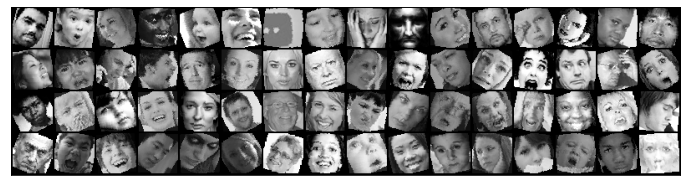

In [49]:
show_batch(train_dl)

# **Using a GPU**

In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [51]:
device = get_default_device()
device

device(type='cuda')

## **Moving the batches of data to GPU if available** 

In [52]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## **Model with Residual Blocks and Batch Normalization**

* ### **Model definition**

In [53]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [54]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

* ### **Pre-trained model**

In [55]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class FacialRecogModel2(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 7)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [56]:
model = to_device(ResNet9(3, 7), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

 # **Training the model**
 Before we train the model, we're going to make a few important improvements to our fit function:

* **Learning rate scheduling**
* **Weight decay**
* **Gradient clipping**

Let's define a fit_one_cycle function to incorporate these changes. We'll also record the learning rate used for each batch.

#### TQDM is made use of to print new progress bars while training.

In [57]:
from tqdm.notebook import tqdm

In [58]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [59]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.945766806602478, 'val_acc': 0.14520473778247833}]

In [60]:
epochs = 25
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [61]:
%%time
history += fit_one_cycle(
    epochs, 
    max_lr, 
    model, 
    train_dl, 
    valid_dl, 
    grad_clip=grad_clip, 
    weight_decay=weight_decay, 
    opt_func=opt_func
                        )


Epoch [0], last_lr: 0.00081, train_loss: 1.6760, val_loss: 1.3775, val_acc: 0.4863



Epoch [1], last_lr: 0.00199, train_loss: 1.4234, val_loss: 1.3875, val_acc: 0.4830



Epoch [2], last_lr: 0.00371, train_loss: 1.3715, val_loss: 1.3271, val_acc: 0.4977



Epoch [3], last_lr: 0.00570, train_loss: 1.3335, val_loss: 1.3319, val_acc: 0.4641



Epoch [4], last_lr: 0.00760, train_loss: 1.3276, val_loss: 1.2355, val_acc: 0.5367



Epoch [5], last_lr: 0.00908, train_loss: 1.3208, val_loss: 1.3039, val_acc: 0.4827



Epoch [6], last_lr: 0.00990, train_loss: 1.3243, val_loss: 1.3388, val_acc: 0.4869



Epoch [7], last_lr: 0.00998, train_loss: 1.3102, val_loss: 1.3350, val_acc: 0.4815



Epoch [8], last_lr: 0.00982, train_loss: 1.2984, val_loss: 1.2310, val_acc: 0.5305



Epoch [9], last_lr: 0.00950, train_loss: 1.2850, val_loss: 1.2086, val_acc: 0.5303



Epoch [10], last_lr: 0.00905, train_loss: 1.2623, val_loss: 1.1638, val_acc: 0.5578



Epoch [11], last_lr: 0.00846, train_loss: 1.2531, val_loss: 1.2902, val_acc: 0.4906



Epoch [12], last_lr: 0.00775, train_loss: 1.2263, val_loss: 1.1446, val_acc: 0.5591



Epoch [13], last_lr: 0.00697, train_loss: 1.2049, val_loss: 1.1200, val_acc: 0.5820



Epoch [14], last_lr: 0.00611, train_loss: 1.1862, val_loss: 1.2262, val_acc: 0.5330



Epoch [15], last_lr: 0.00522, train_loss: 1.1725, val_loss: 1.1282, val_acc: 0.5737



Epoch [16], last_lr: 0.00433, train_loss: 1.1480, val_loss: 1.0671, val_acc: 0.5995



Epoch [17], last_lr: 0.00345, train_loss: 1.1211, val_loss: 1.0590, val_acc: 0.5883



Epoch [18], last_lr: 0.00263, train_loss: 1.0973, val_loss: 1.0124, val_acc: 0.6122



Epoch [19], last_lr: 0.00188, train_loss: 1.0747, val_loss: 1.0036, val_acc: 0.6127



Epoch [20], last_lr: 0.00123, train_loss: 1.0512, val_loss: 1.0088, val_acc: 0.6219



Epoch [21], last_lr: 0.00071, train_loss: 1.0261, val_loss: 0.9814, val_acc: 0.6286



Epoch [22], last_lr: 0.00032, train_loss: 1.0116, val_loss: 0.9677, val_acc: 0.6345



Epoch [23], last_lr: 0.00008, train_loss: 1.0063, val_loss: 0.9660, val_acc: 0.6310



Epoch [24], last_lr: 0.00000, train_loss: 1.0016, val_loss: 0.9635, val_acc: 0.6316
CPU times: user 4min 2s, sys: 27.2 s, total: 4min 29s
Wall time: 17min 40s


In [68]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.9634791612625122, 'val_acc': 0.6315732598304749}]

## **Plotting Functions**

In [62]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

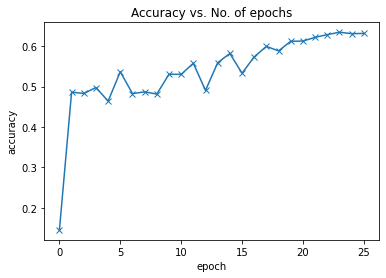

In [63]:
plot_accuracies(history)

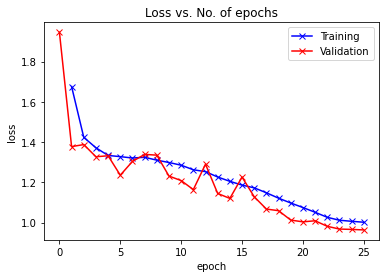

In [64]:
plot_losses(history)

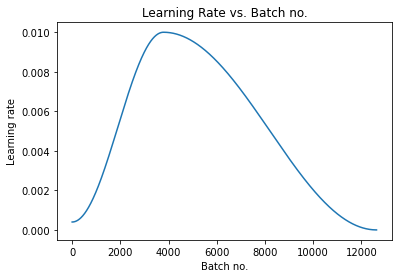

In [65]:
plot_lrs(history)

## **Predictions of The Model**

In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [66]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

Label: anger , Predicted: anger


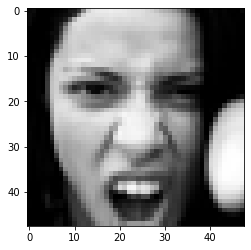

In [70]:
img, label = test_dataset[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: fear , Predicted: fear


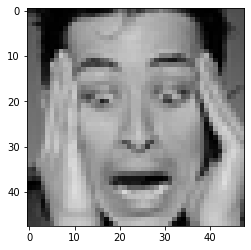

In [71]:
img, label = test_dataset[1039]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: neutral , Predicted: neutral


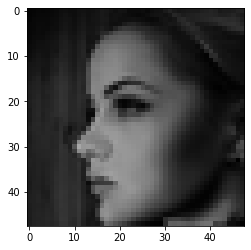

In [73]:
img, label = test_dataset[2314]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))